# Segmentation of Credit Card Customers

## Objective:
To develop a customer segmentation to define marketing strategy and use the derived KPIs to gain insight on the customer profiles and provide the strategic insights and implementation of strategies.

In [1]:
# Importing Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.metrics import mean_squared_error

import pylab
import scipy.stats as stats

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

### UDF

In [2]:
# Use a general function that returns multiple values
def continuous_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), 
                      x.dropna().quantile(0.01), x.dropna().quantile(0.05), x.dropna().quantile(0.10),
                      x.dropna().quantile(0.25), x.dropna().quantile(0.50), x.dropna().quantile(0.75), 
                      x.dropna().quantile(0.90), x.dropna().quantile(0.95), x.dropna().quantile(0.99), x.max()], 
                  index=['N', 'NMISS', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,
                         'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [3]:
# Create Data audit Report for categorical variables
def categorical_summary(x):
    Mode = x.value_counts().sort_values(ascending = False).reset_index()[0:1]
    return pd.Series([x.count(), x.isnull().sum(), x.nunique(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'NUNIQUE', 'MODE', 'FREQ', 'PERCENT'])

In [4]:
# Handling Outliers for numerical data
def outlier_capping(x):
    x = x.clip(upper= x.quantile(0.99), lower= x.quantile(0.01))
    return x

In [5]:
def missing_impute(x, stats = 'mean'):
    if (x.dtypes == 'float64')|(x.dtypes=='int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode()[0])
    return x

In [6]:
def dummy(df,colname):
    col_dummies = pd.get_dummies(df[colname], prefix=colname, drop_first=True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True)
    return df

### Data Pre-Processing 

In [7]:
# reading data into dataframe
credit = pd.read_csv("CC_GENERAL.csv")

In [8]:
# Writing output data into excel
output = pd.ExcelWriter('Segmentation_Customers.xlsx')

In [9]:
credit.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [10]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

**Intital descriptive analysis of data.**

In [11]:
credit.select_dtypes(include='number').apply(continuous_summary).round(1).T

,N,NMISS,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
BALANCE,8950.0,0.0,1564.5,873.4,2081.5,4332775.0,0.0,0.1,8.8,23.6,128.3,873.4,2054.1,4338.6,5909.1,9338.8,19043.1
BALANCE_FREQUENCY,8950.0,0.0,0.9,1.0,0.2,0.1,0.0,0.1,0.3,0.5,0.9,1.0,1.0,1.0,1.0,1.0,1.0
PURCHASES,8950.0,0.0,1003.2,361.3,2136.6,4565208.2,0.0,0.0,0.0,0.0,39.6,361.3,1110.1,2542.6,3998.6,8977.3,49039.6
ONEOFF_PURCHASES,8950.0,0.0,592.4,38.0,1659.9,2755227.9,0.0,0.0,0.0,0.0,0.0,38.0,577.4,1600.1,2671.1,6689.9,40761.2
INSTALLMENTS_PURCHASES,8950.0,0.0,411.1,89.0,904.3,817827.4,0.0,0.0,0.0,0.0,0.0,89.0,468.6,1140.1,1750.1,3886.2,22500.0
CASH_ADVANCE,8950.0,0.0,978.9,0.0,2097.2,4398096.3,0.0,0.0,0.0,0.0,0.0,0.0,1113.8,3065.5,4647.2,9588.2,47137.2
PURCHASES_FREQUENCY,8950.0,0.0,0.5,0.5,0.4,0.2,0.0,0.0,0.0,0.0,0.1,0.5,0.9,1.0,1.0,1.0,1.0
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.0,0.2,0.1,0.3,0.1,0.0,0.0,0.0,0.0,0.0,0.1,0.3,0.8,1.0,1.0,1.0
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.0,0.4,0.2,0.4,0.2,0.0,0.0,0.0,0.0,0.0,0.2,0.8,1.0,1.0,1.0,1.0
CASH_ADVANCE_FREQUENCY,8950.0,0.0,0.1,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.4,0.6,0.8,1.5


In [12]:
credit.select_dtypes(include='object').apply(categorical_summary).T

,N,NMISS,NUNIQUE,MODE,FREQ,PERCENT
CUST_ID,8950,0,8950,C10609,1,0.01


In [13]:
# Droping column 'custid' - Showing high cardinality
credit.drop(['CUST_ID'], axis=1, inplace=True)

## EDA

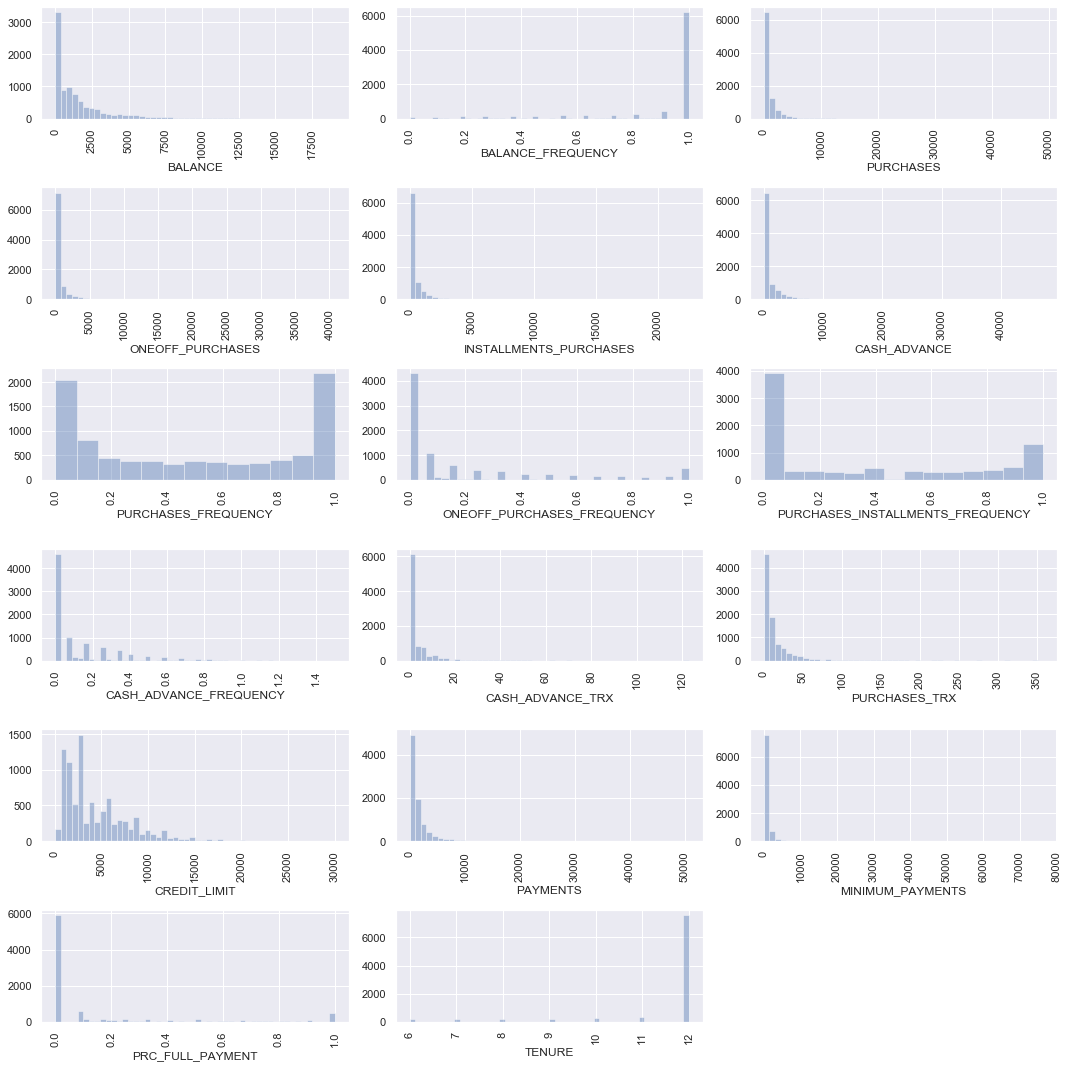

In [14]:
plt.figure(figsize = (15,15))
for i, col in enumerate(credit.columns):
    plt.subplot(6, 3, i+1)
    plt.subplots_adjust(hspace = 1)
    sns.distplot(credit[col], kde=False)
    plt.xticks(rotation = 90)
    plt.tight_layout()
plt.show()

### Outlier Treatment

In [15]:
conti_var = credit.select_dtypes('number').columns
credit[conti_var] = credit[conti_var].apply(lambda x: outlier_capping(x))

### Missing Value Treatment

In [16]:
credit.isnull().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [17]:
# For CREDIT_LIMIT - We will fill the NULL with the median of CREDIT_LIMIT
credit['CREDIT_LIMIT'].fillna(value=credit['CREDIT_LIMIT'].median(), inplace = True)

In [18]:
# For MINIMUM_PAYMENTS we will fill NULL with ZERO
credit['MINIMUM_PAYMENTS'] = credit['MINIMUM_PAYMENTS'].fillna(0)

In [19]:
credit.isnull().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

## Deriving New KPI'S

**Monthly avg_purchase and Cash_Advance Amount**

In [20]:
credit['MONTHLY_AVG_PURCHASE'] = credit['PURCHASES']/credit['TENURE']
credit['MONTHLY_CASH_ADVANCE'] = credit['CASH_ADVANCE']/credit['TENURE']

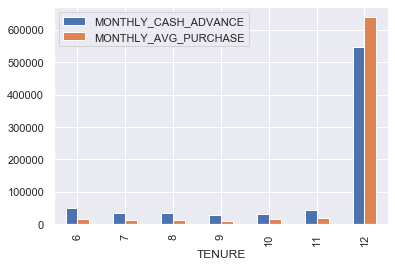

In [21]:
credit.groupby('TENURE')[['MONTHLY_CASH_ADVANCE', 'MONTHLY_AVG_PURCHASE']].sum().plot(kind='bar')
plt.show()

**PURCHASE TYPE**

**To find what type of purchases customers are making on credit card.**

In [22]:
credit.loc[:,['ONEOFF_PURCHASES','INSTALLMENTS_PURCHASES']].head()

,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES
0,0.00,95.4
1,0.00,0.0
2,773.17,0.0
3,1499.00,0.0
4,16.00,0.0


**There are 4 types of purchase behaviour in the data set.**

    1.People who only do One-Off Purchases.
    2.People who only do Installments Purchases.
    3.People who do both.
    4.People who do none.

**So deriving a categorical variable based on the behaviour.**

In [23]:
# function for defining purchase type
def purchase(credit):   
    if (credit['ONEOFF_PURCHASES'] == 0) & (credit['INSTALLMENTS_PURCHASES'] == 0): return 'NONE'
    if (credit['ONEOFF_PURCHASES'] > 0) & (credit['INSTALLMENTS_PURCHASES'] > 0): return 'BOTH'
    if (credit['ONEOFF_PURCHASES'] > 0) & (credit['INSTALLMENTS_PURCHASES'] == 0): return 'ONEOFF'
    if (credit['ONEOFF_PURCHASES'] == 0) & (credit['INSTALLMENTS_PURCHASES'] > 0): return 'INSTALLMENT'

In [24]:
credit['PURCHASE_TYPE'] = credit.apply(purchase, axis=1)

In [25]:
credit['PURCHASE_TYPE'].value_counts()

BOTH           2774
INSTALLMENT    2260
NONE           2042
ONEOFF         1874
Name: PURCHASE_TYPE, dtype: int64

**LIMIT USAGE (balance to credit limit ratio)**

In [26]:
# LIMIT USAGE (Credit Score - Lower value implies customers are maintaining their balance properly)
credit['LIMIT_USAGE'] = credit.apply(lambda x: x['BALANCE']/x['CREDIT_LIMIT'], axis=1)

**Payment to minimum payments Ratio**

In [27]:
# PAYMENT_MINPAYMENT
credit['PAYMENT_MINPAYMENT'] = np.where(credit['MINIMUM_PAYMENTS'] == 0, credit['PAYMENTS'], 
                                        credit['PAYMENTS']/credit['MINIMUM_PAYMENTS'])

In [28]:
# Avarage payment_minpayment ratio
group_purchase = credit.groupby('PURCHASE_TYPE')[['MONTHLY_AVG_PURCHASE', 'MONTHLY_CASH_ADVANCE', 
                                                  'LIMIT_USAGE', 'PAYMENT_MINPAYMENT'] ].mean()
group_purchase

,MONTHLY_AVG_PURCHASE,MONTHLY_CASH_ADVANCE,LIMIT_USAGE,PAYMENT_MINPAYMENT
PURCHASE_TYPE,,,,
BOTH,176.861350,62.972375,0.351471,9.879633
INSTALLMENT,46.139936,36.722734,0.270450,10.801853
NONE,0.000000,176.996706,0.563894,10.683853
ONEOFF,67.284704,76.770332,0.379007,32.140152


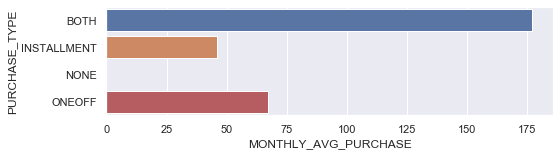

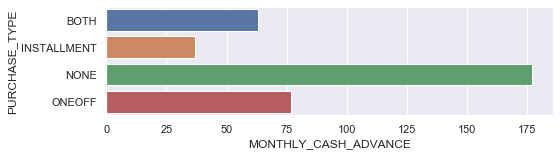

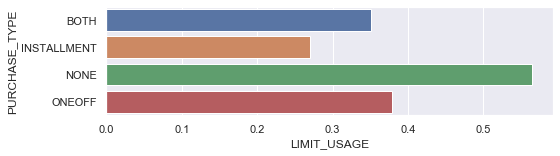

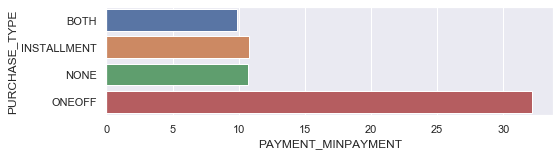

In [29]:
for col in group_purchase.columns:
    plt.figure(figsize=(8,2))
    sns.barplot(y=group_purchase.index, x=col, data = group_purchase) 
plt.show()

### Data Manipulation

### Dummy variables

In [30]:
credit = pd.concat([credit, pd.get_dummies(credit['PURCHASE_TYPE'], prefix='PURCHASE_TYPE')], axis=1)
credit.drop('PURCHASE_TYPE', axis=1, inplace=True)
credit.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,PRC_FULL_PAYMENT,TENURE,MONTHLY_AVG_PURCHASE,MONTHLY_CASH_ADVANCE,LIMIT_USAGE,PAYMENT_MINPAYMENT,PURCHASE_TYPE_BOTH,PURCHASE_TYPE_INSTALLMENT,PURCHASE_TYPE_NONE,PURCHASE_TYPE_ONEOFF
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,0.000000,12,7.950000,0.000000,0.040901,1.446508,0,1,0,0
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,...,0.222222,12,0.000000,536.912124,0.457495,3.826241,0,0,1,0
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,12,64.430833,0.000000,0.332687,0.991682,0,0,0,1
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,0.000000,12,124.916667,17.149001,0.222223,0.000000,0,0,0,1
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,0.000000,12,1.333333,0.000000,0.681429,2.771075,0,0,0,1


### Log Transformation

In [31]:
log = ['BALANCE', 'PURCHASES', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'PAYMENTS', 'MINIMUM_PAYMENTS']
credit[log] = credit[log].apply(lambda x: np.log(x+1))

In [32]:
credit.to_excel(output, 'credit_df', index=False)

#### Correlation

In [33]:
cor = credit.corr()
cor.to_excel(output, 'correlation')

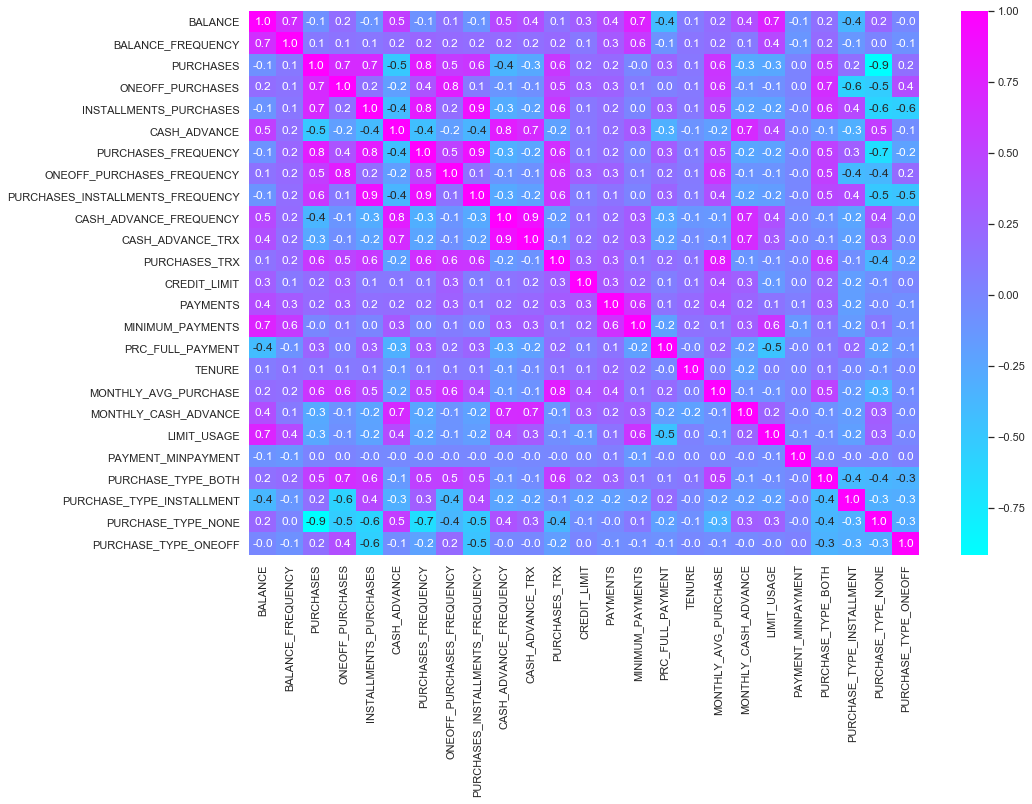

In [34]:
plt.figure(figsize=(15,10))
sns.heatmap(cor, annot=True, cmap='cool', fmt='.1f')
plt.show()

## Preparing for Machine learning

## Standardising the data

In [35]:
from sklearn.preprocessing import  StandardScaler
sc = StandardScaler()
cr_scaled = sc.fit_transform(credit)
cr_scaled = pd.DataFrame(cr_scaled, columns=credit.columns)

In [36]:
cr_scaled.to_excel(output, 'credit_standardscaler', index=False)
cr_scaled.head(2)

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,PRC_FULL_PAYMENT,TENURE,MONTHLY_AVG_PURCHASE,MONTHLY_CASH_ADVANCE,LIMIT_USAGE,PAYMENT_MINPAYMENT,PURCHASE_TYPE_BOTH,PURCHASE_TYPE_INSTALLMENT,PURCHASE_TYPE_NONE,PURCHASE_TYPE_ONEOFF
0,-1.207587,-0.255968,-0.112263,-0.988351,0.396844,-0.931270,-0.806490,-0.678661,-0.707313,-0.685371,...,-0.525551,0.36068,-0.559583,-0.510509,-0.979687,-0.052724,-0.670193,1.720516,-0.543690,-0.514625
1,0.952090,0.132501,-1.682446,-0.988351,-1.088685,1.532002,-1.221758,-0.678661,-0.916995,0.593147,...,0.234227,0.36068,-0.620854,2.704783,0.205564,-0.043437,-0.670193,-0.581221,1.839282,-0.514625


### Applying PCA

In [37]:
credit.shape

(8950, 25)

In [38]:
from sklearn.decomposition import PCA
var_ratio={}
for n in range(1,25):
    pc=PCA(n_components=n)
    cr_pca=pc.fit(cr_scaled)
    var_ratio[n]=sum(cr_pca.explained_variance_ratio_)

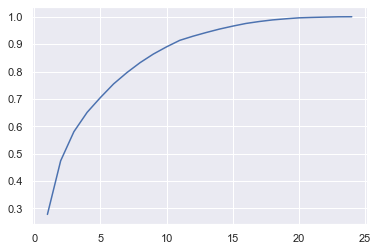

In [39]:
pd.Series(var_ratio).plot()
plt.show()

In [40]:
var_ratio

{1: 0.27819374820801246,
 2: 0.4739344266649942,
 3: 0.5801660379285012,
 4: 0.6508663972899248,
 5: 0.7047303242179558,
 6: 0.7547176690430433,
 7: 0.7958023150773683,
 8: 0.8322738694884482,
 9: 0.8636038704702048,
 10: 0.8900052932443471,
 11: 0.9138324188464952,
 12: 0.9289388648669629,
 13: 0.9424337571340261,
 14: 0.9549507146282111,
 15: 0.9657120668681869,
 16: 0.9754713525207966,
 17: 0.9825283064622166,
 18: 0.9883699432885754,
 19: 0.9924430258655351,
 20: 0.9959563929920437,
 21: 0.9975041034374513,
 22: 0.9987210120617718,
 23: 0.9997792160388069,
 24: 0.9999999999999998}

***Since 8 components are explaning about 80% of the variance we select 8 components***

In [41]:
pca_model = PCA(n_components=8) 
pca_model = pca_model.fit(cr_scaled) 

In [42]:
pca_model.explained_variance_

array([6.95562087, 4.89406378, 2.65608706, 1.76770654, 1.34674967,
       1.2498225 , 1.02723062, 0.91189073])

In [43]:
np.cumsum(pca_model.explained_variance_ratio_)

array([0.27819375, 0.47393443, 0.58016604, 0.6508664 , 0.70473037,
       0.75471768, 0.79580232, 0.83227387])

In [44]:
reduced_cr = pca_model.transform(cr_scaled)
dimensions = pd.DataFrame(reduced_cr)
dimensions.columns = ['PC' + str(i) for i in range(1,9)]

In [45]:
dimensions.to_excel(output, 'reduced_cr', index=False)
dimensions.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,-0.227560,-3.059776,-0.784241,-0.576780,0.349336,-0.274471,0.230543,-0.596569
1,-3.942937,1.590538,-0.665133,0.928098,-1.252467,-1.386866,-0.362999,0.277242
2,1.152871,0.862675,3.043005,-1.391292,0.892851,-0.753608,-0.373472,0.134667
3,-0.726119,-2.356524,3.528608,0.677484,1.186532,1.830057,0.352739,-1.930242
4,-1.400720,-0.879623,1.829135,-2.245347,0.662509,-0.344142,0.066131,0.201502


In [46]:
# variable reduction
Loadings =  pd.DataFrame((pca_model.components_.T * np.sqrt(pca_model.explained_variance_)).T, columns=credit.columns).T
Loadings.columns = ['PC' + str(i) for i in range(1,9)]
Loadings.to_excel(output, 'PCA_Loadings')
Loadings.head(2)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
BALANCE,-0.232976,0.845917,-0.085336,-0.313715,0.024055,0.025557,0.006004,0.055302
BALANCE_FREQUENCY,0.064224,0.598239,-0.224241,-0.446681,0.044377,-0.008004,-0.139029,0.159997


In [48]:
pca_cols = ['BALANCE', 'BALANCE_FREQUENCY', 'CASH_ADVANCE', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'CREDIT_LIMIT', 
            'INSTALLMENTS_PURCHASES', 'LIMIT_USAGE', 'MINIMUM_PAYMENTS', 'MONTHLY_AVG_PURCHASE', 'MONTHLY_CASH_ADVANCE', 
            'ONEOFF_PURCHASES', 'ONEOFF_PURCHASES_FREQUENCY', 'PAYMENTS', 'PAYMENT_MINPAYMENT', 'PURCHASES', 
            'PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'PURCHASES_TRX', 'PURCHASE_TYPE_BOTH', 
            'PURCHASE_TYPE_ONEOFF']

### Variables after manual profiling
**['BALANCE', 'BALANCE_FREQUENCY', 'CASH_ADVANCE', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'CREDIT_LIMIT', 'INSTALLMENTS_PURCHASES', 'LIMIT_USAGE', 'MINIMUM_PAYMENTS', 'MONTHLY_AVG_PURCHASE', 'MONTHLY_CASH_ADVANCE', 'ONEOFF_PURCHASES', 'ONEOFF_PURCHASES_FREQUENCY', 'PAYMENTS', 'PAYMENT_MINPAYMENT', 'PURCHASES', 'PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'PURCHASES_TRX', 'PURCHASE_TYPE_BOTH', 'PURCHASE_TYPE_ONEOFF']**

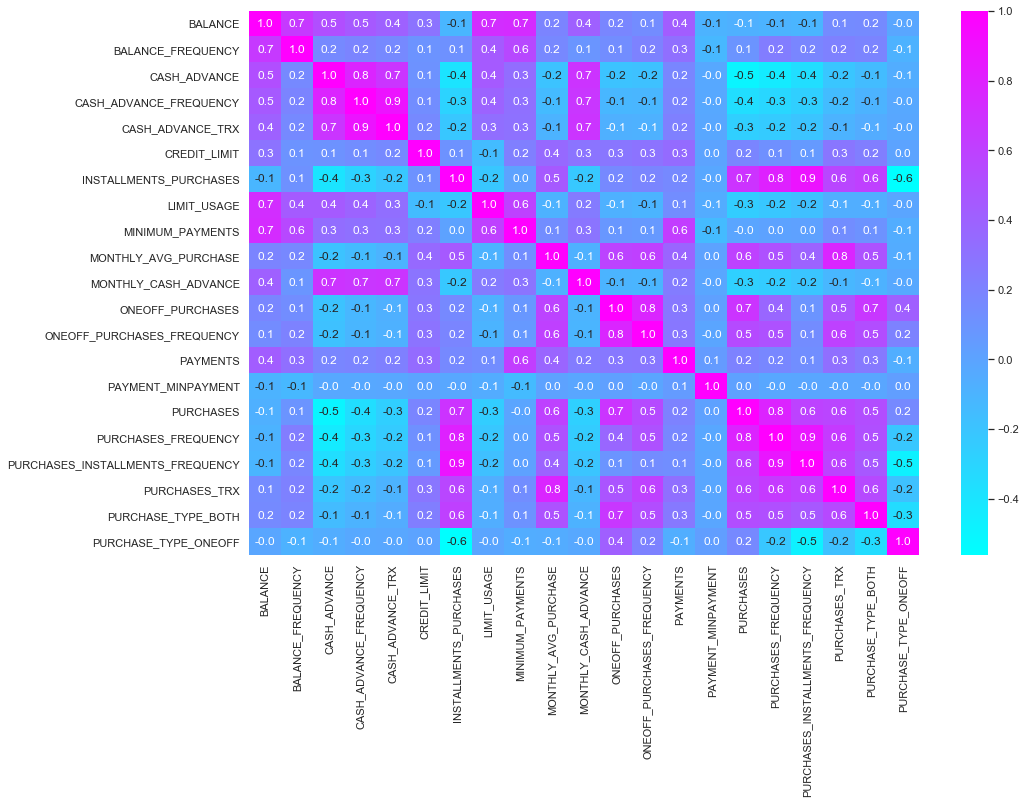

In [49]:
plt.figure(figsize=(15,10))
sns.heatmap(cr_scaled[pca_cols].corr(), annot=True, cmap='cool', fmt='.1f')
plt.show()

In [50]:
selected_cols = ['BALANCE', 'BALANCE_FREQUENCY', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'INSTALLMENTS_PURCHASES', 'LIMIT_USAGE', 
                 'MINIMUM_PAYMENTS', 'MONTHLY_AVG_PURCHASE', 'MONTHLY_CASH_ADVANCE', 'ONEOFF_PURCHASES', 'PAYMENTS', 
                 'PAYMENT_MINPAYMENT', 'PURCHASES', 'PURCHASE_TYPE_BOTH', 'PURCHASE_TYPE_ONEOFF']

### Final variables based on heat map
**['BALANCE', 'BALANCE_FREQUENCY', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'INSTALLMENTS_PURCHASES', 'LIMIT_USAGE', 
'MINIMUM_PAYMENTS', 'MONTHLY_AVG_PURCHASE', 'MONTHLY_CASH_ADVANCE', 'ONEOFF_PURCHASES', 'PAYMENTS', 
'PAYMENT_MINPAYMENT', 'PURCHASES', 'PURCHASE_TYPE_BOTH', 'PURCHASE_TYPE_ONEOFF']**

## Clustering

In [51]:
from sklearn import metrics
from sklearn.cluster import KMeans

In [52]:
# Calculating Silhouette Score for K = 2 to 20
k_range = range(2,20)
scores = []
wcss = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(reduced_cr)
    scores.append(metrics.silhouette_score(reduced_cr, km.labels_))
    wcss.append(km.inertia_)

#### Silhouette Coefficient

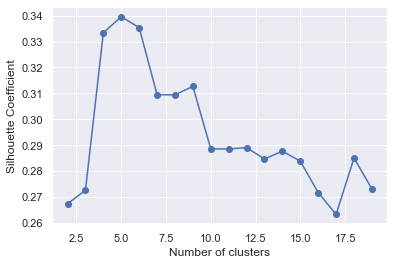

In [53]:
# plot the Silhouette Coefficient
plt.plot(k_range, scores, marker = "o")
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

**Based of Silhouette Score, optimal value of k lies between 4 to 6**

#### Pseudo F-Score

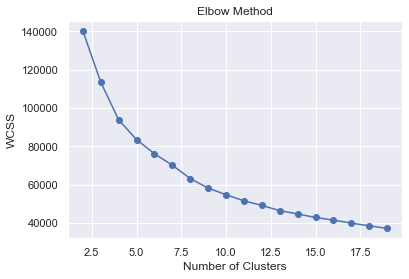

In [54]:
# Pseudo F-Score(Elbow Method)
plt.plot(k_range, wcss, marker = "o" )
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

**Based of Pseudo F-Score, optimal k value lies between 3 to 5**

### Final range that we can try is 3 to 6

In [55]:
# getting anti log of the log transformation
credit[log] = credit[log].apply(lambda x: np.exp(x)-1)

In [56]:
df = credit.copy()

In [57]:
# Building Cluster with k value from 3 to 8
km_3 = KMeans(n_clusters = 3, random_state = 1).fit(reduced_cr)
km_4 = KMeans(n_clusters = 4, random_state = 1).fit(reduced_cr)
km_5 = KMeans(n_clusters = 5, random_state = 1).fit(reduced_cr)
km_6 = KMeans(n_clusters = 6, random_state = 1).fit(reduced_cr)

In [58]:
df['Cluster_3'] = km_3.labels_
df['Cluster_4'] = km_4.labels_
df['Cluster_5'] = km_5.labels_
df['Cluster_6'] = km_6.labels_

In [59]:
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,LIMIT_USAGE,PAYMENT_MINPAYMENT,PURCHASE_TYPE_BOTH,PURCHASE_TYPE_INSTALLMENT,PURCHASE_TYPE_NONE,PURCHASE_TYPE_ONEOFF,Cluster_3,Cluster_4,Cluster_5,Cluster_6
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,0.040901,1.446508,0,1,0,0,0,0,1,0
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,...,0.457495,3.826241,0,0,1,0,1,3,2,3
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.332687,0.991682,0,0,0,1,2,1,0,1
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,0.222223,0.000000,0,0,0,1,0,1,0,4
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,0.681429,2.771075,0,0,0,1,0,1,0,1


## Creating a DataFrame for Manual Profiling

In [60]:
# Creating Profile DataFrame
profile = pd.concat([df.apply(lambda x: x.mean()).T,
                     df.groupby('Cluster_3').apply(lambda x: x.mean()).T,
                     df.groupby('Cluster_4').apply(lambda x: x.mean()).T,
                     df.groupby('Cluster_5').apply(lambda x: x.mean()).T,
                     df.groupby('Cluster_6').apply(lambda x: x.mean()).T],
                     axis = 1)

In [61]:
# Naming Profile Columns
profile.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                              'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                              'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                              'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5', 'KM6_6']

In [62]:
profile

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,KM5_3,KM5_4,KM5_5,KM6_1,KM6_2,KM6_3,KM6_4,KM6_5,KM6_6
BALANCE,1541.046707,457.811749,2422.964573,1958.092923,573.762890,1319.902813,1901.412840,2301.254098,1015.832365,481.789838,1966.112119,1594.595960,4189.951277,624.419309,1267.230982,1566.449231,2121.393318,79.105518,4319.106019
BALANCE_FREQUENCY,0.878083,0.764795,0.920660,0.973558,0.804289,0.829817,0.966281,0.890442,0.813021,0.799721,0.878942,0.963012,0.972267,0.887423,0.898604,0.962896,0.920533,0.341680,0.971110
PURCHASES,936.229237,496.456387,112.590519,2339.616786,496.903600,697.797864,2269.293954,19.299802,689.896271,492.129986,0.434852,2349.432697,844.931277,548.753317,800.919713,2309.214731,0.482075,210.208413,876.990882
ONEOFF_PURCHASES,536.493774,177.352118,93.053193,1443.225976,9.849235,690.508175,1343.195471,7.125043,683.140366,7.519044,0.038270,1394.219171,504.194182,0.431870,788.500554,1364.018425,0.040744,128.647729,525.064961
INSTALLMENTS_PURCHASES,384.498368,319.480345,19.580018,845.910261,486.150414,0.554091,879.311380,12.213943,1.032090,483.659850,0.406786,905.875750,328.553560,546.254270,0.484555,899.245559,0.452194,81.625663,341.176381
CASH_ADVANCE,935.920972,114.656082,2147.251408,685.350141,204.603108,697.376093,726.633146,2135.859025,325.579520,114.734224,1643.369243,287.582485,4417.392246,167.792085,431.214120,294.624767,1731.097632,192.354507,4653.283962
PURCHASES_FREQUENCY,0.490351,0.554562,0.079108,0.840510,0.695550,0.317881,0.826172,0.024201,0.318822,0.694516,0.001332,0.837223,0.475041,0.750974,0.349255,0.835011,0.001464,0.235396,0.480412
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.090719,0.050674,0.498997,0.007540,0.316992,0.461619,0.005672,0.316933,0.005953,0.000170,0.474276,0.209869,0.000838,0.348612,0.468583,0.000181,0.070021,0.222548
PURCHASES_INSTALLMENTS_FREQUENCY,0.364437,0.443054,0.026711,0.620027,0.654530,0.001200,0.657534,0.017101,0.002179,0.655229,0.001162,0.668236,0.322054,0.712964,0.001051,0.669352,0.001237,0.159308,0.324546
CASH_ADVANCE_FREQUENCY,0.134017,0.022484,0.297769,0.100774,0.031583,0.109994,0.108165,0.290310,0.067535,0.021755,0.249701,0.054377,0.507432,0.030147,0.083869,0.055317,0.260620,0.030639,0.531320


In [63]:
# Getting size of clusters
size = pd.concat([pd.Series(len(df)),
                  pd.Series.sort_index(df.Cluster_3.value_counts()),
                  pd.Series.sort_index(df.Cluster_4.value_counts()),
                  pd.Series.sort_index(df.Cluster_5.value_counts()),
                  pd.Series.sort_index(df.Cluster_6.value_counts())])

size = pd.DataFrame(size.reset_index(drop = True), columns = ['Seg_size'])
size.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Seg_size,8950,3371,2850,2729,2300,1821,2610,2219,1641,2186,1960,2325,838,1872,1427,2342,1841,731,737


In [64]:
# Getting cluster percentage
seg_per = pd.DataFrame((size.values/df.Cluster_3.size), columns = ['Seg_perc'])
seg_per.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Seg_perc,1.0,0.376648,0.318436,0.304916,0.256983,0.203464,0.29162,0.247933,0.183352,0.244246,0.218994,0.259777,0.093631,0.209162,0.159441,0.261676,0.205698,0.081676,0.082346


In [65]:
size_perc = pd.concat([size.T, seg_per.T])
size_perc.columns = ['Overall', 'KM3_1', 'KM3_2', 'KM3_3',
                                'KM4_1', 'KM4_2', 'KM4_3', 'KM4_4',
                                'KM5_1', 'KM5_2', 'KM5_3', 'KM5_4', 'KM5_5',
                                'KM6_1', 'KM6_2', 'KM6_3', 'KM6_4', 'KM6_5', 'KM6_6']

In [66]:
size_perc

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,KM5_3,KM5_4,KM5_5,KM6_1,KM6_2,KM6_3,KM6_4,KM6_5,KM6_6
Seg_size,8950.0,3371.000000,2850.000000,2729.000000,2300.000000,1821.000000,2610.00000,2219.000000,1641.000000,2186.000000,1960.000000,2325.000000,838.000000,1872.000000,1427.000000,2342.000000,1841.000000,731.000000,737.000000
Seg_perc,1.0,0.376648,0.318436,0.304916,0.256983,0.203464,0.29162,0.247933,0.183352,0.244246,0.218994,0.259777,0.093631,0.209162,0.159441,0.261676,0.205698,0.081676,0.082346


In [67]:
profile_final = pd.concat([size_perc, profile])
profile_final

,Overall,KM3_1,KM3_2,KM3_3,KM4_1,KM4_2,KM4_3,KM4_4,KM5_1,KM5_2,KM5_3,KM5_4,KM5_5,KM6_1,KM6_2,KM6_3,KM6_4,KM6_5,KM6_6
Seg_size,8950.000000,3371.000000,2850.000000,2729.000000,2300.000000,1821.000000,2610.000000,2219.000000,1641.000000,2186.000000,1960.000000,2325.000000,838.000000,1872.000000,1427.000000,2342.000000,1841.000000,731.000000,737.000000
Seg_perc,1.000000,0.376648,0.318436,0.304916,0.256983,0.203464,0.291620,0.247933,0.183352,0.244246,0.218994,0.259777,0.093631,0.209162,0.159441,0.261676,0.205698,0.081676,0.082346
BALANCE,1541.046707,457.811749,2422.964573,1958.092923,573.762890,1319.902813,1901.412840,2301.254098,1015.832365,481.789838,1966.112119,1594.595960,4189.951277,624.419309,1267.230982,1566.449231,2121.393318,79.105518,4319.106019
BALANCE_FREQUENCY,0.878083,0.764795,0.920660,0.973558,0.804289,0.829817,0.966281,0.890442,0.813021,0.799721,0.878942,0.963012,0.972267,0.887423,0.898604,0.962896,0.920533,0.341680,0.971110
PURCHASES,936.229237,496.456387,112.590519,2339.616786,496.903600,697.797864,2269.293954,19.299802,689.896271,492.129986,0.434852,2349.432697,844.931277,548.753317,800.919713,2309.214731,0.482075,210.208413,876.990882
ONEOFF_PURCHASES,536.493774,177.352118,93.053193,1443.225976,9.849235,690.508175,1343.195471,7.125043,683.140366,7.519044,0.038270,1394.219171,504.194182,0.431870,788.500554,1364.018425,0.040744,128.647729,525.064961
INSTALLMENTS_PURCHASES,384.498368,319.480345,19.580018,845.910261,486.150414,0.554091,879.311380,12.213943,1.032090,483.659850,0.406786,905.875750,328.553560,546.254270,0.484555,899.245559,0.452194,81.625663,341.176381
CASH_ADVANCE,935.920972,114.656082,2147.251408,685.350141,204.603108,697.376093,726.633146,2135.859025,325.579520,114.734224,1643.369243,287.582485,4417.392246,167.792085,431.214120,294.624767,1731.097632,192.354507,4653.283962
PURCHASES_FREQUENCY,0.490351,0.554562,0.079108,0.840510,0.695550,0.317881,0.826172,0.024201,0.318822,0.694516,0.001332,0.837223,0.475041,0.750974,0.349255,0.835011,0.001464,0.235396,0.480412
ONEOFF_PURCHASES_FREQUENCY,0.202458,0.090719,0.050674,0.498997,0.007540,0.316992,0.461619,0.005672,0.316933,0.005953,0.000170,0.474276,0.209869,0.000838,0.348612,0.468583,0.000181,0.070021,0.222548


In [68]:
profile_final.to_excel(output, 'Profiling_final')

### Visualization of Cluster

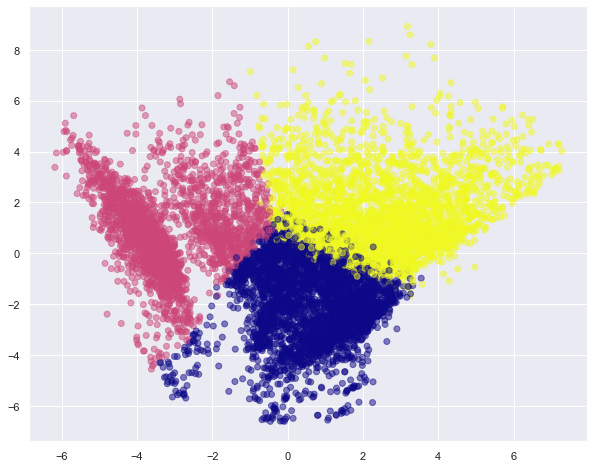

In [69]:
plt.figure(figsize=(10,8))
plt.scatter(reduced_cr[:,0], reduced_cr[:,1], c=km_3.labels_.astype(float), cmap='plasma', alpha=0.5)
plt.show()

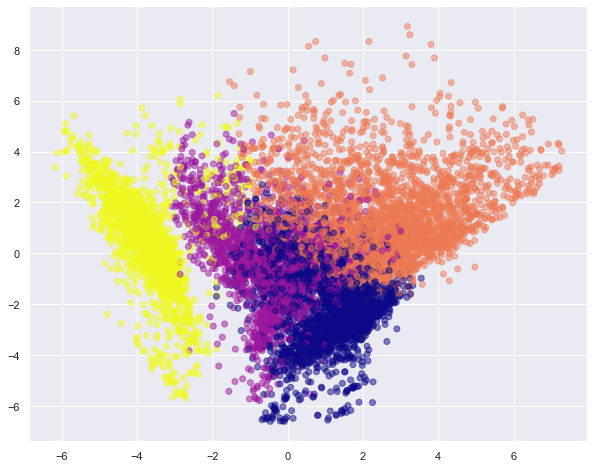

In [70]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_cr[:,0], reduced_cr[:,1], c=km_4.labels_.astype(float), cmap='plasma', alpha=0.5)
plt.show()

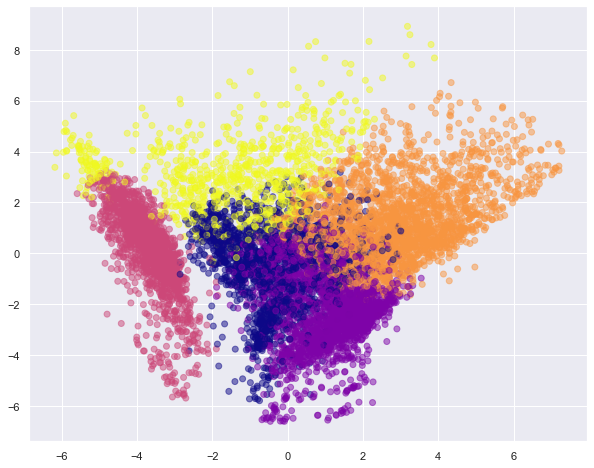

In [71]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_cr[:,0], reduced_cr[:,1], c=km_5.labels_.astype(float), cmap='plasma', alpha=0.5)
plt.show()

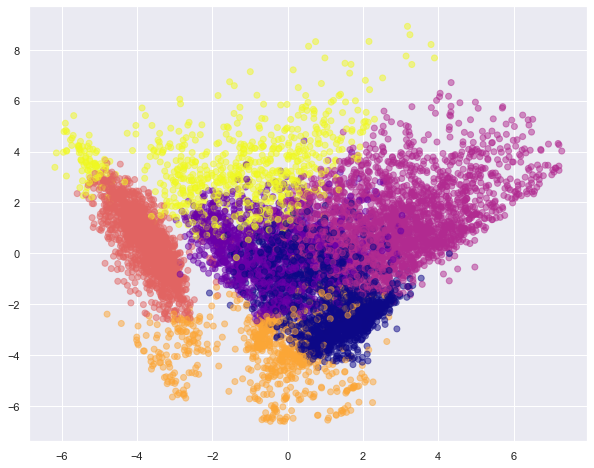

In [72]:
plt.figure(figsize=(10, 8))
plt.scatter(reduced_cr[:,0], reduced_cr[:,1], c=km_6.labels_.astype(float), cmap='plasma', alpha=0.5)
plt.show()

#### Based on manual profiling and Silhouette score we will opt for 4 cluster solution 
* As there are lot of  people that are having high balances and doing less purchases and do the payment on time and can be targeted with new offers.
* Then there we have people who only do small purchases in EMI's.
* Cluster 3 and 4 have cutomers with high balance and high purchase and can be our most valuable customers.

# Checking performance metrics for Kmeans

In [73]:
from sklearn.metrics import calinski_harabasz_score, silhouette_score
score={}
score_c={}
for n in range(2,20):
    km_score=KMeans(n_clusters=n)
    km_score.fit(reduced_cr)
    score_c[n]=calinski_harabasz_score(reduced_cr,km_score.labels_)
    score[n]=silhouette_score(reduced_cr,km_score.labels_)

In [74]:
score={}
score_c={}
for n in range(2,20):
    km_score=KMeans(n_clusters=n)
    km_score.fit(reduced_cr)
    score_c[n]=calinski_harabasz_score(reduced_cr,km_score.labels_)
    score[n]=silhouette_score(reduced_cr,km_score.labels_)

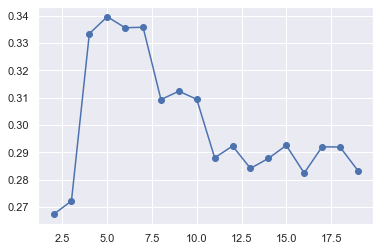

In [75]:
pd.Series(score).plot(marker = "o")
plt.show()

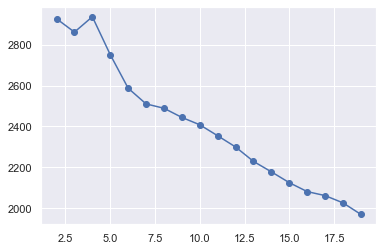

In [76]:
pd.Series(score_c).plot(marker = "o")
plt.show()

## Performance metrics also suggest that K-means with 4 cluster is able to show distinguished characteristics between each cluster.

#### 4 Clusters solution are clearly distinguishing with follwing references

<B> Cluster 1 </B> - This group is about 26% of the total customer base.
This group is paying dues and are doing maximum ***installment purchase.***

<B> Cluster 2 </B> - This group is about 20% of the total customer base.
This group is more inclined to ***ON_OFF purchases*** and have high payment_minpayment.

<B> Cluster 3 </B> - This group is about 29% of the total customer base.
This group of customers have highest monthly Avarage Purchases and have good Credit Score.
This group is doing ***both installment as well as one off purchases*** and have comparetively low payment_minpayment.

<B> Cluster 4 </B> - This group is about 25% of the total customer base.
This group is taking maximum cash advance and has poor credit score.
This group is more inclined to ***NO purchase*** transaction.

### Finding behaviour with 4 Clusters:

In [77]:
# Concatenate labels found through Kmeans with data 
cluster_df_4 = pd.concat([credit, pd.Series(km_4.labels_, name='Cluster_4')], axis=1)
cluster_df_4.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,...,TENURE,MONTHLY_AVG_PURCHASE,MONTHLY_CASH_ADVANCE,LIMIT_USAGE,PAYMENT_MINPAYMENT,PURCHASE_TYPE_BOTH,PURCHASE_TYPE_INSTALLMENT,PURCHASE_TYPE_NONE,PURCHASE_TYPE_ONEOFF,Cluster_4
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,...,12,7.950000,0.000000,0.040901,1.446508,0,1,0,0,0
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,...,12,0.000000,536.912124,0.457495,3.826241,0,0,1,0,3
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,...,12,64.430833,0.000000,0.332687,0.991682,0,0,0,1,1
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,...,12,124.916667,17.149001,0.222223,0.000000,0,0,0,1,1
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,...,12,1.333333,0.000000,0.681429,2.771075,0,0,0,1,1


In [78]:
# Mean value gives a good indication of the distribution of data. So we are finding mean 
# value for each variable for each cluster
cluster_4 = cluster_df_4.groupby('Cluster_4').apply(lambda x: x.mean()).T
cluster_4

Cluster_4,0,1,2,3
BALANCE,573.762890,1319.902813,1901.412840,2301.254098
BALANCE_FREQUENCY,0.804289,0.829817,0.966281,0.890442
PURCHASES,496.903600,697.797864,2269.293954,19.299802
ONEOFF_PURCHASES,9.849235,690.508175,1343.195471,7.125043
INSTALLMENTS_PURCHASES,486.150414,0.554091,879.311380,12.213943
CASH_ADVANCE,204.603108,697.376093,726.633146,2135.859025
PURCHASES_FREQUENCY,0.695550,0.317881,0.826172,0.024201
ONEOFF_PURCHASES_FREQUENCY,0.007540,0.316992,0.461619,0.005672
PURCHASES_INSTALLMENTS_FREQUENCY,0.654530,0.001200,0.657534,0.017101
CASH_ADVANCE_FREQUENCY,0.031583,0.109994,0.108165,0.290310


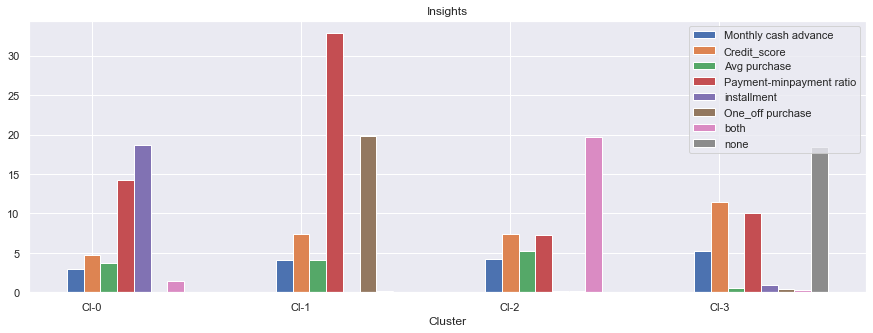

In [79]:
fig,ax = plt.subplots(figsize=(15,5))
index = np.arange(len(cluster_4.columns))

cash_advance = np.log(cluster_4.loc['MONTHLY_CASH_ADVANCE',:].values)
credit_score = cluster_4.loc['LIMIT_USAGE',:].values*20
purchase = np.log(cluster_4.loc['MONTHLY_AVG_PURCHASE',:].values)
payment = cluster_4.loc['PAYMENT_MINPAYMENT',:].values
installment = cluster_4.loc['PURCHASE_TYPE_INSTALLMENT',:].values*20
one_off = cluster_4.loc['PURCHASE_TYPE_ONEOFF',:].values*20
both = cluster_4.loc['PURCHASE_TYPE_BOTH',:].values*20
none = cluster_4.loc['PURCHASE_TYPE_NONE',:].values*20

bar_width = .08
b1 = plt.bar(index, cash_advance, label='Monthly cash advance', width=bar_width)
b2 = plt.bar(index+bar_width, credit_score, label='Credit_score', width=bar_width)
b3 = plt.bar(index+2*bar_width, purchase, label='Avg purchase', width=bar_width)
b4 = plt.bar(index+3*bar_width, payment, label='Payment-minpayment ratio', width=bar_width)
b5 = plt.bar(index+4*bar_width, installment, label='installment', width=bar_width)
b6 = plt.bar(index+5*bar_width, one_off, label='One_off purchase', width=bar_width)
b7 = plt.bar(index+6*bar_width, both, label='both', width=bar_width)
b8 = plt.bar(index+7*bar_width, none, label='none', width=bar_width)

plt.xlabel("Cluster")
plt.title("Insights")
plt.xticks(index + bar_width, ('Cl-0', 'Cl-1', 'Cl-2', 'Cl-3'))
plt.legend()
plt.show()

## Insights

**Clusters are clearly distinguishing behavior within customers**

**Findings through clustering is validating Insights dervied from KPI. (as shown above in Insights from KPI)**

In [80]:
# exporting the file
cluster_4.to_excel(output, 'cluster_4')

In [81]:
# Saving the output file
output.save()

# Marketing Strategy Suggested:

### Group 0 
**They are potential target customers who are paying dues and doing purchases and maintaining comparatively good credit score ) -- we can increase credit limit or can lower down interest rate -- Can be given premium card /loyality cards to increase transactions**

### Group 1 
**This group has minimum paying ratio and using card for just oneoff transactions (may be for utility bills only). This group seems to be risky group.**

### Group 2 
**This group is performing best among all as cutomers are maintaining good credit score and paying dues on time. -- Giving rewards point will make them perform more purchases.**


### Group 3
**They have poor credit score and taking only cash on advance. We can target them by providing less interest rate on purchase transaction**